In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np 
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
os.chdir('/mmfs1/gscratch/cheme/dalba/repos/ECFERS')

In [3]:
inputs_df = pd.read_csv('data/inputs.csv')
inputs_df.columns = ['sample','objective','time','dilution_factor','C00058','C00004','C00037','C00149','C00022','C00065','C00036','C00002','C00020','C00010','C00033','C00158HCT','C00011','C00024','p_hEC11719', 'p_hEC11137','p_hEC6411','p_hEC43117']
inputs_df['time'] = inputs_df['time'].apply(lambda x: (x*60+15)*60)
inputs_df.sort_values(['objective','time','sample'], inplace=True)

data_df = pd.read_csv('data/data.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_stds = pd.read_csv('data/data_stds.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_df.columns = ['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','C00047','C00183','C00109','C02630']
data_stds.columns = ['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','C00047','C00183','C00109','C02630']
data_weights_df = pd.read_csv('data/data_weights_mod.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()

In [4]:
def split_df(df, test_on):
    test_vars_df = df[df['sample'].apply(lambda x: any(name in x for name in test_on))]
    train_vars_df = df[~df['sample'].apply(lambda x: any(name in x for name in test_on))]
    return [test_vars_df, train_vars_df]

# test_on = ['pyc_HCT','pyc_HCT_dil','PI', 'es','E_N','TP']
test_on = ['gly','mal','ser','pyr','empty']
test_on = ['gly','mal','ser','pyr','empty','tdcb','pyc','mdh']
test_vars_df, train_vars_df, test_data_df, train_data_df, test_weights_df, train_weights_df, test_stds_df, train_stds_df =  sum([split_df(df, test_on) for df in [inputs_df, data_df, data_weights_df, data_stds]],[])

In [5]:
# test_weights_df = test_weights_df.set_index('sample')
# test_weights_df[test_weights_df<1] = 0.0001
# test_weights_df = test_weights_df.reset_index()

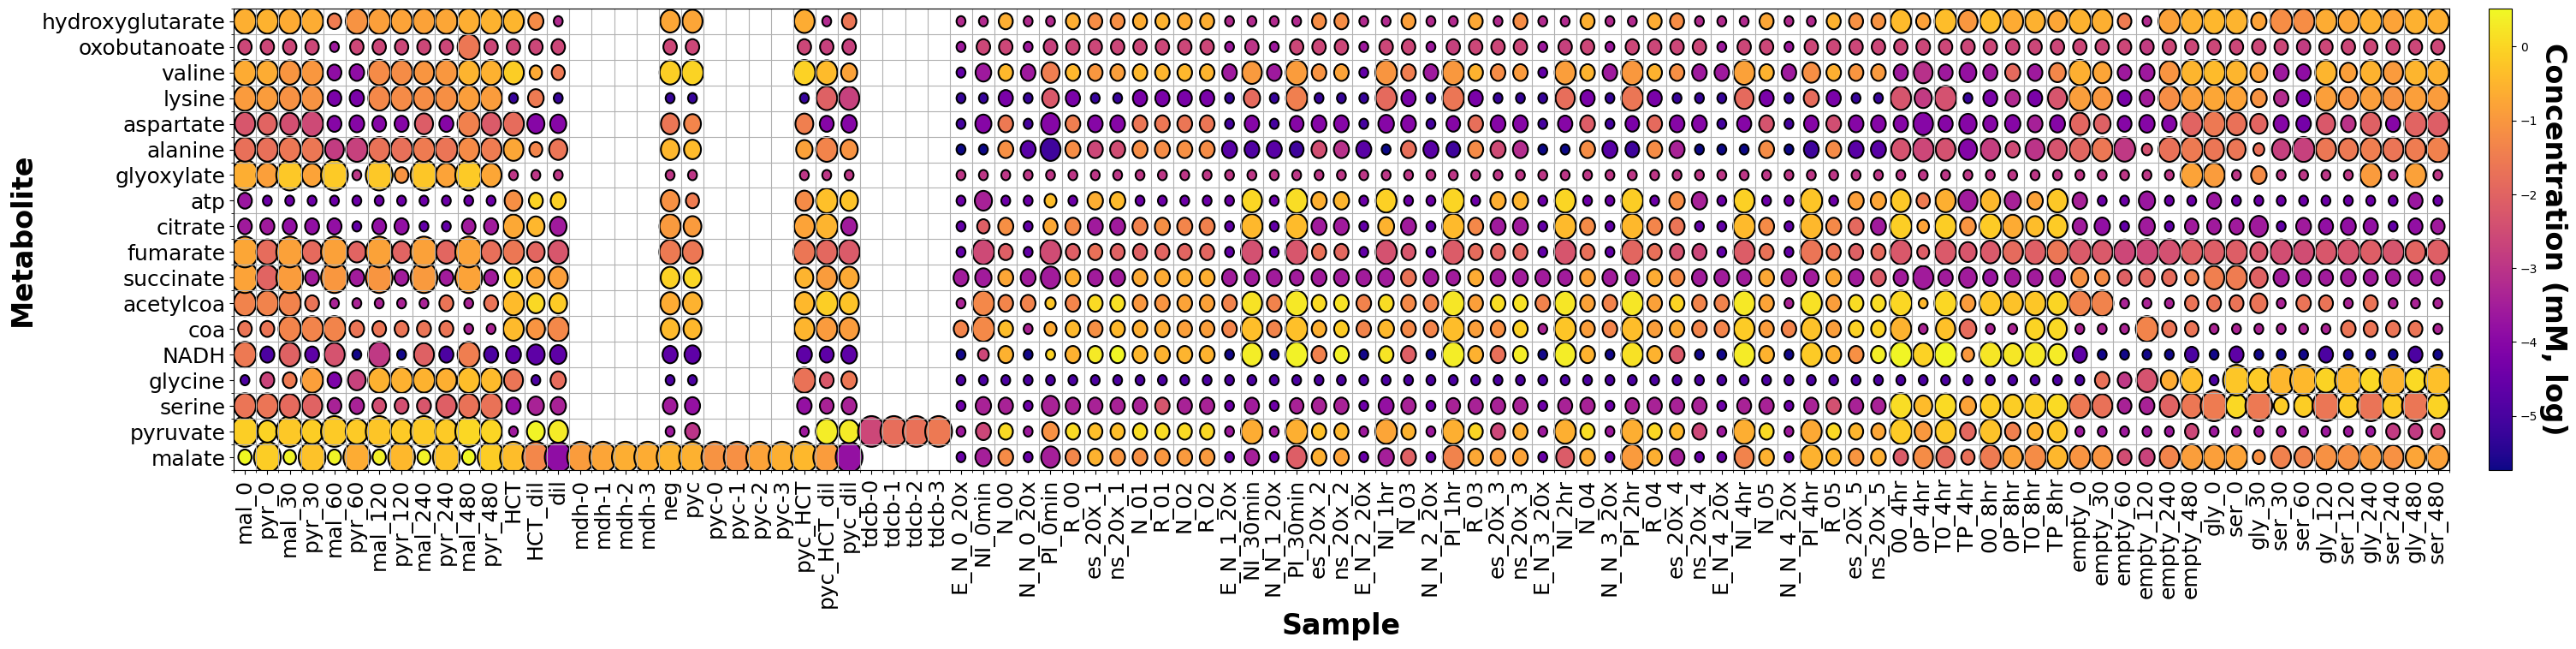

In [6]:
from matplotlib.collections import PatchCollection

def circlemap(data_df, data_weights_df, figsize=(40, 7), ignore = None, log = True, cmap = 'plasma'):
       if ignore:
              data_df = data_df[:-ignore]
              data_weights_df = data_weights_df[:-ignore]
       N, M = data_df.T.shape
       ylabels = data_weights_df.drop(columns=['sample'],inplace=False).columns
       xlabels = data_df['sample']

       x, y = np.meshgrid(np.arange(M), np.arange(N-1))
       s = data_weights_df.drop(columns=['sample'], inplace=False).T.values
       if log:
              c = np.log10(data_df.drop(columns=['sample'], inplace=False).T.values)
       else:
              c = data_df.drop(columns=['sample'], inplace=False).T.values
       fig, ax = plt.subplots(figsize=figsize)

       s[s>1]=1.2
       R = s/2
       circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
       col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='black', linewidth=1.5)
       ax.add_collection(col)

       ax.set(xticks=np.arange(M), yticks=np.arange(N-1),
              xticklabels=xlabels, yticklabels=ylabels)
       ax.set_xticks(np.arange(M+1)-0.5, minor=True)
       ax.set_yticks(np.arange(N)-0.5, minor=True)
       ax.grid(which='minor')

       plt.xticks(rotation=90)
       plt.tick_params(axis='both', which='major', labelsize=18)

       cbar = fig.colorbar(col, pad = 0.015)
       if log:
              cbar.set_label('Concentration (mM, log)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})
       else:
              cbar.set_label('Concentration (mM)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})


       plt.xlabel('Sample', fontsize=24, fontdict={'weight': 'bold'})
       plt.ylabel('Metabolite', fontsize=24, fontdict={'weight': 'bold'})

       plt.show()
       
circlemap(data_df, data_weights_df)

In [7]:
test_index_map = pd.merge(test_vars_df, test_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index','objective']].sort_values(['index','time'])
train_index_map = pd.merge(train_vars_df, train_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index','objective']].sort_values(['index','time'])

In [8]:
train_vars = [train_vars_df.drop(columns=['sample','time','objective'], inplace=False).drop_duplicates().T.to_dict()]
test_vars = [test_vars_df.drop(columns=['sample','time','objective'], inplace=False).drop_duplicates().T.to_dict()]

train_metadata = [{}]
train_metadata[0]['sample_labels'] = list(train_vars[0].keys())
train_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
train_metadata[0]['timepoints'] = train_index_map.groupby('index')['time'].apply(list).to_dict()
train_metadata[0]['objective'] = train_index_map.drop_duplicates('index')['objective'].values

test_metadata = [{}]
test_metadata[0]['sample_labels'] = list(test_vars[0].keys())
test_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
test_metadata[0]['timepoints'] = test_index_map.groupby('index')['time'].apply(list).to_dict()
test_metadata[0]['objective'] = test_index_map.drop_duplicates('index')['objective'].values

train_data=[{}]
train_weights=[{}]
for index, samples in train_index_map.groupby('index')['sample'].apply(list).items():
    train_data[0][index]=train_data_df.loc[train_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    train_weights[0][index]=train_weights_df.loc[train_weights_df['sample'].isin(samples)].drop(columns=['sample']).values

test_data=[{}]
test_weights=[{}]
for index, samples in test_index_map.groupby('index')['sample'].apply(list).items():
    test_data[0][index]=test_data_df.loc[test_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    test_weights[0][index]=test_weights_df.loc[test_weights_df['sample'].isin(samples)].drop(columns=['sample']).values


In [9]:
# load SBML model
modelfile = os.getcwd()+'/models/M3a.sbml'
r = te.loadSBMLModel(modelfile)

In [10]:
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat_V' in p]
keq_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]==1]
keq2_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]!=1]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]
kdeg_labels= [p for p in r.getGlobalParameterIds() if 'kdeg' in p]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in  [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s):sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s)+5]).split(' ')[0] for s in metabolites] if 'v' in v]
heterologous_expression = [p for p in r.getGlobalParameterIds() if 'rel' in p][1:]

# parameter_labels = kcat_labels + keq_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + kdeg_labels + metabolites_labels + heterologous_expression
parameter_labels = kcat_labels + keq_labels + keq2_labels + km_labels + kdeg_labels + metabolites_labels + heterologous_expression
# parameter_labels = metabolites_labels + heterologous_expression
parameter_labels.append('rel0') # what are good bounds for this?
# parameter_labels.append('t0') 

# make upper and lower bounds
upper = np.log10(np.array(
                  [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)*100000 for i in kcat_labels] + 
                 [100000 for i in keq_labels] +
                 [r[i]*3 for i in keq2_labels] +
                 [r[i]*100000 for i in km_labels] + 
                #  [r[i]*10000 for i in ki_labels] +
                #  [1 for _ in Gnc_labels] +
                #  [1 for _ in Gc_labels] +
                #  [r[i]*1000 for i in kdeg_labels] +
                 [100000 for _ in metabolites_labels] + 
                 [100000 for _ in heterologous_expression] +
                 [100000]))# +
                #  [150*60]))

lower = np.log10(np.array(
                [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)/100000 for i in kcat_labels] + 
                 [1/100000 for i in keq_labels] +
                 [r[i]/3 for i in keq2_labels] +
                 [r[i]/100000 for i in km_labels] + 
                #  [r[i]/10000 for i in ki_labels] +
                #  [1/100 for _ in Gnc_labels] +
                #  [1/100 for _ in Gc_labels] +
                #  [r[i]/1000 for i in kdeg_labels] +
                 [1/100000 for _ in metabolites_labels] + 
                 [1/100000 for _ in heterologous_expression] +
                 [1/100000]))# +
                #  [1*60]))

p_initial = np.log10(np.array(
                    [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5) for i in kcat_labels] + 
                     [r[i] for i in keq_labels] +
                     [r[i] for i in keq2_labels] +
                     [r[i] for i in km_labels] + 
                    #  [r[i] for i in ki_labels] +
                    #  [0.9 for _ in Gnc_labels] +
                    #  [0.9 for _ in Gc_labels] +
                    #  [r[i] for i in kdeg_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1 for _ in heterologous_expression] +
                     [1]))# +
                    #  [15*60]))

widths = np.log10(np.array(
                  [100 for _ in kcat_labels] +
                  [100 for _ in keq_labels] + 
                  [2 for i in keq2_labels] +
                  [100 for _ in km_labels] + 
                #   [10000 for _ in ki_labels] +
                #   [1 for _ in Gnc_labels] +
                #   [1 for _ in Gc_labels] +
                  # [10 for _ in kdeg_labels] +
                  [1000 for _ in metabolites_labels] + 
                  [1000 for _ in heterologous_expression] +
                  [1000]))# +
                  # [10]))

In [ ]:
def split_parameters_and_variables(parameter_labels, p_initial, lower, uppper, variables, split_by):
    from copy import deepcopy
    all_pl, all_pi, all_l, all_u, all_v = [],[],[],[],[]
    for split in split_by: # list of lists with parameter labels
        parameter_labels_s, p_initial_s, lower_s, upper_s, variables_s = [],[],[],[], deepcopy(variables)
        for i, l in enumerate(parameter_labels):
            if l in split:
                parameter_labels_s += [parameter_labels[i]] 
                p_initial_s += [p_initial[i]]
                lower_s += [lower[i]]
                upper_s += [upper[i]]
            else:
                for sample in variables_s.keys():
                    variables_s[sample][parameter_labels[i]] = 10**p_initial[i] # variables are not log transformed
        all_pl += [parameter_labels_s]
        all_pi += [p_initial_s]
        all_l += [np.array(lower_s)]
        all_u += [np.array(upper_s)]
        all_v += [variables_s]
    return all_pl, all_pi, all_l, all_u, all_v


all_pl, all_pi, all_l, all_u, all_v = split_parameters_and_variables(parameter_labels, p_initial, lower, upper, test_vars[0], 
                                    [kcat_labels+metabolites_labels, keq_labels+metabolites_labels, km_labels+metabolites_labels, ki_labels+metabolites_labels, Gnc_labels + Gc_labels + metabolites_labels, heterologous_expression+['rel0'] +metabolites_labels])

from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
test_myprobs = [SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = test_data, 
    data_weights=test_weights,
    parameter_labels=pl, 
    lower_bounds=l, upper_bounds=u, 
    metadata=test_metadata,
    variables=[v],
    scale=True,
    log=[True]*len(pl),
    elambda=1,
    dlambda = 10,
    llambda=0, 
    rmse='mean') for pl, l, u, v in zip(all_pl, all_l, all_u, all_v)]

In [11]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = train_data, 
    data_weights=train_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=train_metadata,
    variables=train_vars,
    extra_residuals = [None],
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=1,
    ldlambda2 = 1,
    lllambda2=1,
    rmse='mean',
    objf='multi_range')

test_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = test_data, 
    data_weights=test_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=test_metadata,
    variables=test_vars,
    extra_residuals = [[
                            [5,23,'C00122'],[5,23,'C00042'],[5,23,'C00048'], # fumarate, succinate, malate
                            [5,23,'C00022'], [11,23,'C00149'],[0,23,'C00065'],[17,23,'C00037'], # pyruvate, malate, serine, glycine
                            # [31,36,'C00149'],[29,36,'C00149'],[30,29,'C00149']#,[32,33,'C00149'], # HCT-neg, dil-neg, HCT_dil-dil, pycpyc_dil
                            [90,87,'C00022'],[98,95,'C00149'],[94,91,'C00149'] # tdcb, mdh, pyc
                            ]], #[[[5,23,'C00022'],[5,23,'C00122'],[5,23,'C00042'],[5,23,'C00048']]], 
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=1,
    ldlambda2 = 100,
    lclambda2 = 1, 
    lllambda2=1,
    rmse='sum',
    objf='multi_comb',
    fitness_std = False)

# test_myprob._set_nominal_fitness([9.4e-1, 7.9e-6, 1.7e+0, 2.9e-1])
# train_myprob._set_nominal_fitness([9.4e-1, 7.9e-6, 1.7e+0, 2.9e-1])

# train_myprob._set_nominal_fitness([0.9, 0.3, 1, 0.3])
# test_myprob._set_nominal_fitness([0.9, 0.3, 1, 0.3])

test_myprob.nominal_fitness = [1,1,1,1,1,1]

# with open('results/241004_M3_spiked/241004_train_myprob.obj', 'wb') as file:
#     pickle.dump(train_myprob, file)

test_myprobs = [test_myprob]*6
train_probs = [pg.problem(p) for p in test_myprobs] # SWAPED THEM HERE FOR TESTING
test_prob = pg.problem(train_myprob)

In [12]:
test_myprob._setup_rr()
test_myprob.fitness(p_initial)

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (200

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:631: RuntimeWarning:

Mean of empty slice.

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:




[480.4617226301707,
 482.70528373317774,
 482.2795318099934,
 527.2620761376714,
 480.76660756480373]

In [13]:
import ipyparallel as ipp
from src.fitting.pygmo_bfes import pickleless_bfe2

client = ipp.Client(profile='cheme-ecfers')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS');

def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())

client[:].apply_sync(set_affinity_on_worker)

total_engines= range(len(client[:]))
engine_chunks =  len(total_engines) // 6
client_partitions = [list(total_engines[i * engine_chunks:(i + 1) * engine_chunks]) for i in range(6)]

In [22]:
[udi._views[i].push({'prob_train': p, 'prob_test': test_prob }, block = True) for i,(udi,p) in enumerate(zip(udis,train_probs))]
[udi._views[i].apply_async(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train')) for i,udi in enumerate(udis)]
[udi._views[i].apply_async(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test')) for i,udi in enumerate(udis)];

In [23]:
[udi._views[i].apply_sync(lambda x: x._views[i].push({'prob_train': p, 'prob_test': test_prob }, block = True), ipp.Reference('udbfe')) for i,(udi,p) in enumerate(zip(udis,train_probs))]
[udi._views[i].apply_sync(lambda x: x._views[i].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train')), ipp.Reference('udbfe')) for i,udi in enumerate(udis)];

In [36]:
[udi._views[i].apply_sync(lambda x: x._views[i].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._set_nominal_fitness([1]*6), ipp.Reference('prob_train')), ipp.Reference('udbfe')) for i,udi in enumerate(udis)];

In [14]:
algos_dicts = [{'algo':'pso', 'gen':10, 'omega':0.95, 'eta1':0.25, 'eta2':0.25, 'max_vel':0.1, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True},
               {'algo':'pso', 'gen':10, 'omega':0.95, 'eta1':0.25, 'eta2':2.05, 'max_vel':0.1, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True},
               {'algo':'pso', 'gen':10, 'omega':0.95, 'eta1':2.05, 'eta2':0.25, 'max_vel':0.1, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True},
               {'algo':'pso', 'gen':10, 'omega':0.95, 'eta1':0.25, 'eta2':0.25, 'max_vel':0.5, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True},
               {'algo':'pso', 'gen':10, 'omega':0.7298, 'eta1':0.25, 'eta2':0.25, 'max_vel':0.5, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True},
               {'algo':'pso', 'gen':10, 'omega':0.7298, 'eta1':2.05, 'eta2':2.05, 'max_vel':0.5, 'variant':5, 'neighb_type':2, 'neighb_param':4, 'memory':True}]

# algos_dicts = [{'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
#                {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'weighted', 'neighbours':20, 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
#                {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':3, 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
#                {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':7, 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
#                {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':len(test_on), 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
#                {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':len(list(test_vars[0].keys())), 'CR':1, 'F':0.5, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True}]

               
algos_dicts = [{'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':1, 'F':0.3, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
               {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':1, 'F':0.6, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
               {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':1, 'F':0.9, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
               {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':0.8, 'F':0.3, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
               {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':0.8, 'F':0.6, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True},
               {'algo':'moead', 'gen':10, 'weight_generation':'low discrepancy', 'decomposition':'tchebycheff', 'neighbours':20, 'CR':0.8, 'F':0.9, 'eta_m':20, 'realb':0.9, 'limit':2, 'preserve_diversity':True}]



In [15]:
from src.fitting.pygmo_islands import my_ipyparallel_island
udis = [my_ipyparallel_island(id = i, client_kwargs={'n':6}, view_kwargs={}, 
                              bfe_client_kwargs={'profile':'cheme-ecfers'}, bfe_view_kwargs = {'targets':client_partitions[i]}, 
                              bfe_kwargs={'temp_dv_path':os.getcwd()+'/models/binaries', 'prob' :{'train':p, 'test':test_prob}}, 
                              algo_kwargs=algos_dicts[i]) for i,p in enumerate(train_probs)]
[u.init_view() for u in udis];

In [16]:
bestN = lambda N,pops: np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[np.argsort(p.get_f()[:,0])[:N],:]) for p in pops])
sampleM_fromN = lambda M,N,pops: np.random.multivariate_normal(np.mean(bestN(N,pops),0),np.cov(bestN(N,pops),rowvar=False),size=M)

with open('results/241206_M3a/pops_init_wk_wkeq_2.dat', 'rb') as file:
    pops_init= pickle.load(file)

N = 300
xs = [sampleM_fromN(N,112,pops_init) for p in train_probs]
ar_fs = [u.run_eval(p,x, block=False) for u,x,p in zip(udis,xs, train_probs)]
fs = [pickle.loads(ar.get()).reshape(N,-1) for ar in ar_fs]

In [21]:
import numpy as np
N = 300
xs = [np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p-w,p+w, N)) for p,w in zip(p_initial,widths)])).T for i in range(6)]
# xs = [pg.batch_random_decision_vector(p, N).reshape(N,-1) for p in train_probs]
ar_fs = [u.run_eval(p,x, block=False) for u,x,p in zip(udis,xs, train_probs)]
fs = [pickle.loads(ar.get()).reshape(N,-1) for ar in ar_fs]

In [16]:
[udi._views[i].apply_sync(lambda x: x._views[i].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly).all_fitness, ipp.Reference('prob_train')), ipp.Reference('udbfe')) for i,udi in enumerate(udis)];

In [17]:
pops = [pg.population(pg.problem(p), size = 0) for p in test_myprobs] # not the problem with _r initialized
[list(map(p.push_back, x, f)) for p,x,f in zip(pops,xs,fs)];

In [22]:
with open('results/241219_M3a/pops0_multi_wkeq_2.dat', 'wb') as file:
    pickle.dump(pops, file)

In [16]:
with open('results/241219_M3a/pops0_multi_wkeq.dat', 'rb') as file:
    pops = pickle.load(file)

In [19]:
# helper functions
topN = lambda n,pop: np.argsort(pop.get_f()[:,0])[:n]
botN = lambda n,pop: np.argsort(pop.get_f()[:,0])[-n:]
getX = lambda pop, idx: pop.get_x()[idx]
getF = lambda pop, idx: pop.get_f()[idx]
makeXDB = lambda n, pops: np.concatenate([getX(p,topN(n,p)) for p in pops])
makeFDB = lambda n, pops: np.concatenate([getF(p,topN(n,p)) for p in pops])
pickIDX = lambda n,k,N: [np.random.choice(n, k, replace=False) for i in range(N)]
# helper functions
topN = lambda n,pop: pg.sort_population_mo(pop.get_f())[:n]
botN = lambda n,pop: pg.sort_population_mo(pop.get_f())[-n:]

In [46]:
def getGlobalX(pop, idx, prob_local, full_p_dict = {k:v for k,v in zip(parameter_labels, p_initial)}): # all unscaled, and log
    X = prob_local._unscale(pop.get_x()[idx])
    gX = []
    p = {k:v for k,v in full_p_dict.items()}
    
    for x in X:
        for k,v in zip(prob_local.parameter_labels, x):
            p[k] = v
        gX.append(list(p.values()))
    return np.array(gX)

def setLocalX(gx, prob_local, parameter_labels=parameter_labels):
    gx_dict = {k:v for k,v in zip(parameter_labels, gx)}
    x = np.array([gx_dict[k] for k in prob_local.parameter_labels])
    return prob_local._scale(x)

In [28]:
getGlobalX(pops[0], [0], test_myprobs[0])[0].shape

(1491,)

In [34]:
setLocalX(getGlobalX(pops[0], [0], test_myprobs[0])[0],test_myprobs[-3]).shape

(509,)

In [174]:
def set_vars(prob, new_vars_dict):
    old_variables = prob.extract(SBMLGlobalFit_Multi_Fly).variables[0]
    new_variables = {}
    for sample, var_dict in old_variables.items():
        for k,v in new_vars_dict.items():
                var_dict[k] = v
        new_variables[sample] = var_dict
    prob.extract(SBMLGlobalFit_Multi_Fly).variables[0] = new_variables

In [175]:
client[:].apply_sync(set_vars, ipp.Reference('prob_train'), {k:10**v for k,v in zip(parameter_labels, p_initial)});
client[:].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly).variables, ipp.Reference('prob_train'))

In [18]:
with open('results/241206_M3a/pops_init_wk_all_multi_3.dat', 'rb') as file:
    pops =pickle.load(file)
with open('results/241206_M3a/logs_init_wk_all_multi_3.dat', 'rb') as file:
    logs=pickle.load(file)
with open('results/241206_M3a/fs_init_wk_all_multi_3.dat', 'rb') as file:
    all_fs=pickle.load(file)

In [98]:
with open('results/241025_M3/fs_M.dat', 'wb') as file:
        pickle.dump(fs, file)

In [23]:
from datetime import datetime  
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")

logs = []
all_fs = []
for i in range(500):
    print(now() + ' - Starting evolution ' + str(i))
    ar_fs = [u.run_evolve(None,pop, block=False) for u,pop in zip(udis,pops)] # submot asynchroneously
    [ar.get() for ar in ar_fs]; # wait for all to finish
    pops = [u._load_pop() for u in udis] # load the population from the engines/storage
    
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.get_f().mean(1).min() for p in pops])))

    logs.append([udi._views[i].apply_sync(lambda x: x.extract(pg.moead_gen).get_log(), ipp.Reference('algo')) for i,udi in enumerate(udis)])
    all_fs.append([p.get_f() for p in pops])

    all_f = np.array([p.get_f() for p in pops]).reshape(-1,test_myprob.get_nobj())
    print(all_f[np.argmin((all_f**2).sum(1))])

    # # Selection and replacement
    if i % 3 == 0:
        print(now() + ' - Starting migration ' + str(i))
        seleect_n = 30
        replace_n = 3
        XDB = makeXDB(seleect_n,pops) # this needs to make the global parameters 
        FDB = makeFDB(seleect_n,pops)
        replace = pickIDX(len(XDB),replace_n,len(pops))
        [[p.set_xf(k, XDB[i], FDB[i]) for i,k in zip(r,botN(len(r),p)) if not np.any(np.all(XDB[i]==p.get_x(),1))] for r,p in zip(replace,pops)]; # need to check if already in pop. this needs to make the problem-specific parameters
        # also need a way to set the variables for each problem, in all engines. 
        print(now() + ' - Migration done ' + str(i))

    with open('results/241219_M3a/pops_multi_wkeq_2.dat', 'wb') as file:
        pickle.dump(pops, file)
    with open('results/241219_M3a/logs_multi_wkeq_2.dat', 'wb') as file:
        pickle.dump(logs, file)
    with open('results/241219_M3a/fs_multi_wkeq_2.dat', 'wb') as file:
        pickle.dump(all_fs, file)


26-12-2024, 16:12:37 - Starting evolution 0
26-12-2024, 16:19:36 - Evolution done. Best fitness: 3.4616689917664614
[1.50101424 3.75224046 3.06439615 7.21687306 1.79855708]
26-12-2024, 16:19:36 - Starting migration 0
26-12-2024, 16:19:36 - Migration done 0
26-12-2024, 16:19:36 - Starting evolution 1
26-12-2024, 16:26:35 - Evolution done. Best fitness: 3.461743788766337
[1.50101424 3.75224046 3.06439615 7.21687306 1.79855708]
26-12-2024, 16:26:35 - Starting evolution 2
26-12-2024, 16:33:38 - Evolution done. Best fitness: 3.461382448559091
[1.50101424 3.75224046 3.06439615 7.21687306 1.79855708]
26-12-2024, 16:33:38 - Starting evolution 3
26-12-2024, 16:40:33 - Evolution done. Best fitness: 3.459098496869321
[1.50101424 3.75224046 3.06439615 7.21687306 1.79855708]
26-12-2024, 16:40:33 - Starting migration 3
26-12-2024, 16:40:33 - Migration done 3
26-12-2024, 16:40:33 - Starting evolution 4
26-12-2024, 16:47:31 - Evolution done. Best fitness: 3.459098496869321
[1.50101424 3.75224046 3.064

In [38]:
all_fs[-1][0][:,0].max()

65.22630066426363

In [185]:
test_myprob._setup_rr()
test_myprob.fitness(all_x[1084])

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:563: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:563: RuntimeWarning:

invalid value encountered in divide



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 26) + inhomogeneous part.

In [41]:
pops

[Problem name: Global Fitting of Multiple SBML Models
 	C++ class name: pybind11::object
 
 	Global dimension:			399
 	Integer dimension:			0
 	Fitness dimension:			3
 	Number of objectives:			3
 	Equality constraints dimension:		0
 	Inequality constraints dimension:	0
 	Lower bounds: [0, 0, 0, 0, 0, ... ]
 	Upper bounds: [1, 1, 1, 1, 1, ... ]
 	Has batch fitness evaluation: false
 
 	Has gradient: false
 	User implemented gradient sparsity: false
 	Has hessians: false
 	User implemented hessians sparsity: false
 
 	Fitness evaluations: 0
 
 	Thread safety: none
 
 Population size: 300
 
 List of individuals: 
 #0:
 	ID:			1696384000842030539
 	Decision vector:	[0.186857, 0.288042, 0.551375, 0.0318015, 0.472922, ... ]
 	Fitness vector:		[50.2771, 94.5635, 0.425617]
 #1:
 	ID:			12527114601963685731
 	Decision vector:	[1.05495, 0.29288, 0.822906, 0.790787, 0.711714, ... ]
 	Fitness vector:		[49.298, 115.896, 0.425618]
 #2:
 	ID:			932426043718857820
 	Decision vector:	[0.463677, 0.22573

In [16]:

dcols = test_myprob.model_stuff[0].data_cols[5]
weights = test_myprob.data_weights[0][5]
# appply error function, then weights
wsq_e = (test_myprob.current_error[0]**2)*weights[:,dcols]
wsq_de = (test_myprob.current_d_erorr[0]**2)*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
wsq_le = (test_myprob.current_log_erorr[0]**2)*weights[:,dcols]

wl_e = np.log1p(np.abs(test_myprob.current_error[0]))*weights[:,dcols]
wl_de = np.log1p(np.abs(test_myprob.current_d_erorr[0]))*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
wl_le = np.log1p(np.abs(test_myprob.current_log_erorr[0]))*weights[:,dcols]

wrmse_e2 = np.sqrt(np.nansum(wsq_e)/(np.nansum((~np.isnan(wsq_e)))+1e-12))
wrmse_de2 = np.sqrt(np.nansum(wsq_de)/(np.nansum((~np.isnan(wsq_de)))+1e-12))
wrmse_le2 = np.sqrt(np.nansum(wsq_le)/(np.nansum((~np.isnan(wsq_le)))+1e-12))

wll_e2 = np.nansum(wl_e)/(np.nansum((~np.isnan(wl_e)))+1e-12)
wll_de2 = np.nansum(wl_de)/(np.nansum((~np.isnan(wl_de)))+1e-12)
wll_le2 = np.nansum(wl_le)/(np.nansum((~np.isnan(wl_le)))+1e-12)


In [17]:
[wll_e2, wll_de2, wll_le2]

[0.197094915330815, 2.422916264873745e-05, 1.0111719370395746]

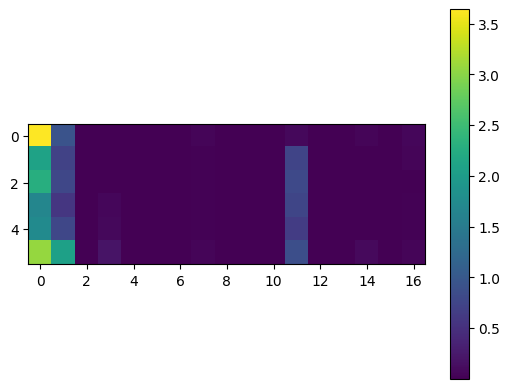

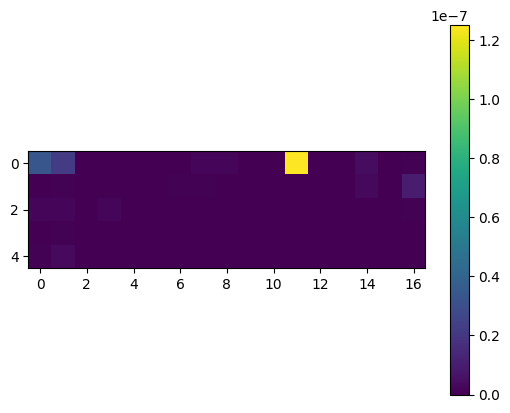

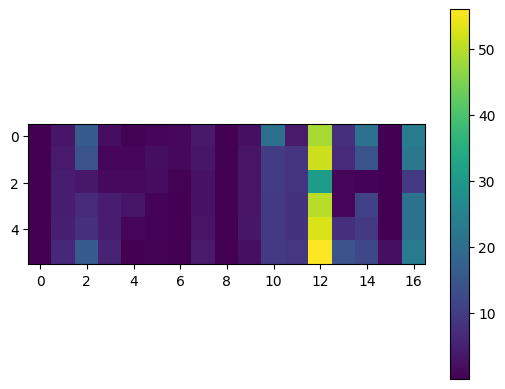

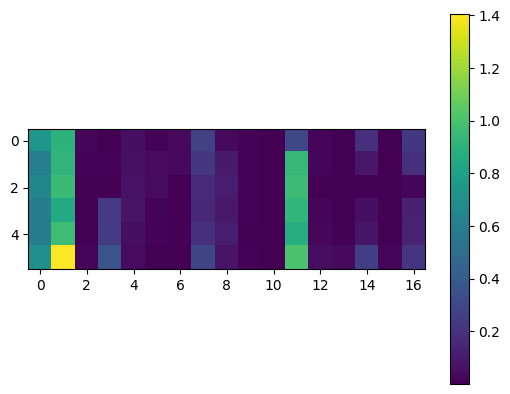

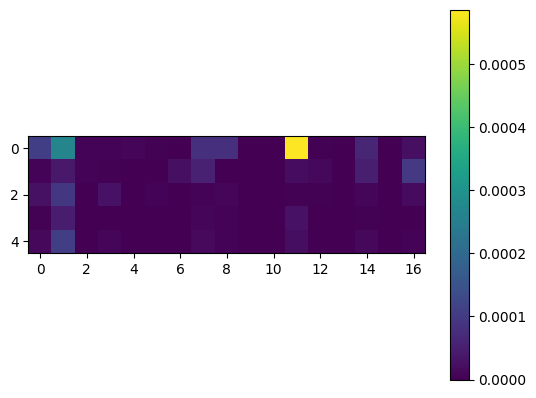

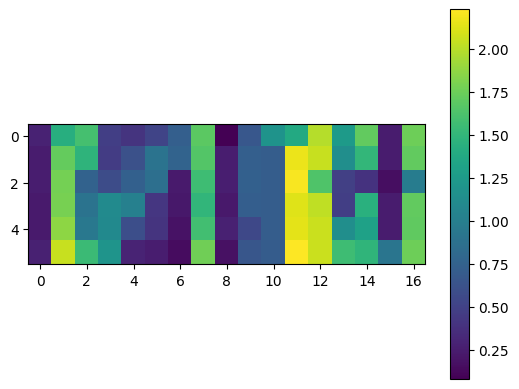

In [18]:
plt.imshow(wsq_e)
plt.colorbar()

plt.figure()
plt.imshow(wsq_de)
plt.colorbar()

plt.figure()
plt.imshow(wsq_le)
plt.colorbar()

plt.figure()
plt.imshow(wl_e)
plt.colorbar()

plt.figure()
plt.imshow(wl_de)
plt.colorbar()

plt.figure()
plt.imshow(wl_le)
plt.colorbar()

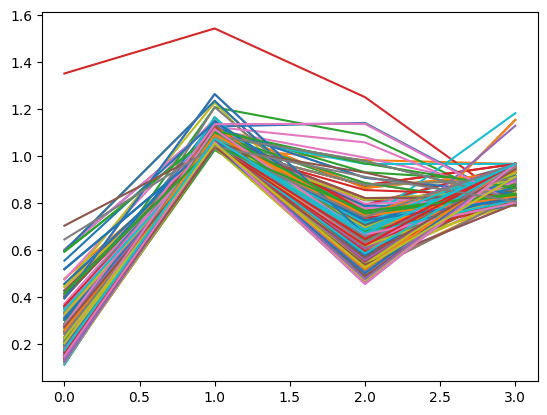

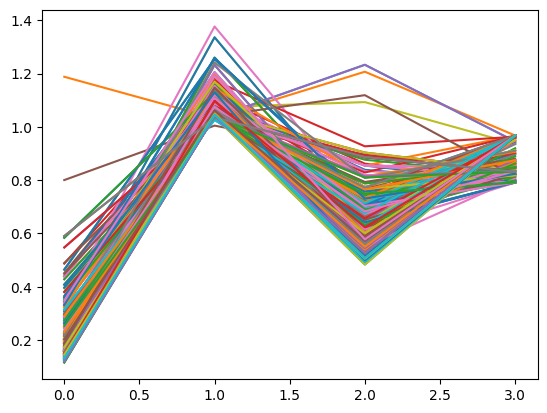

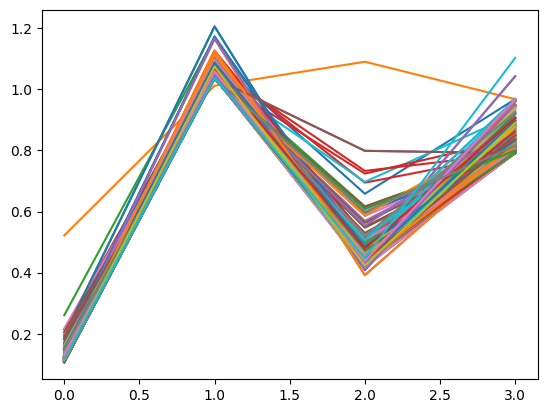

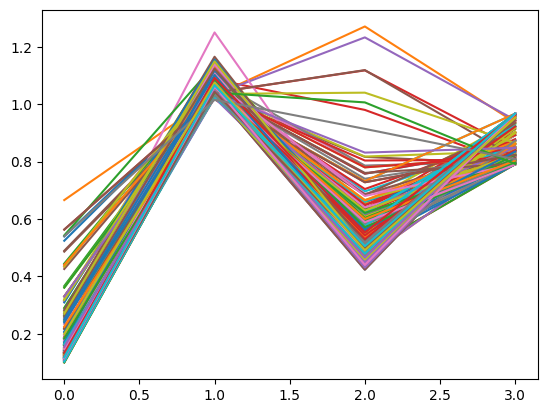

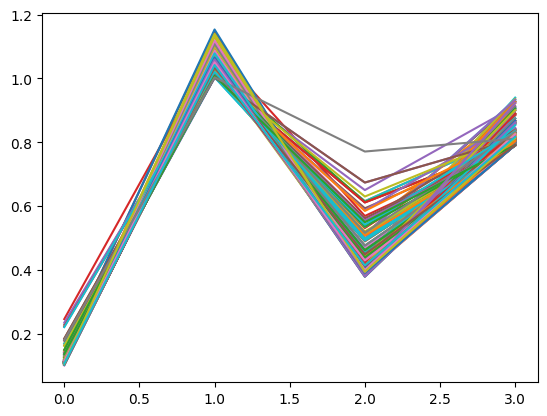

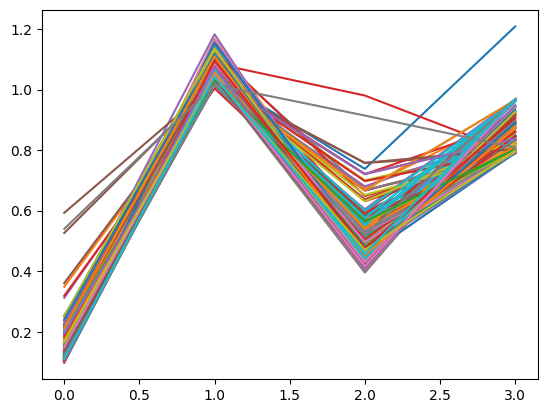

In [77]:
for f in all_fs:
    plt.figure()
    plt.plot(f[0].T)
    plt.figure()
    plt.plot(f[-3].T)

In [195]:
np.nansum(list(np.nanmean([test_myprob._residual(test_myprob.data[0][s]*2,test_myprob.data[0][s],test_myprob.data_weights[0][s],s,test_myprob.model_stuff[0],test_myprob.metadata[0]) for s in test_myprob.metadata[0]['sample_labels']],axis=0)) +  [test_myprob._extra_residual(resdict,data,weights,ms) for data,weights,ms,resdict,md in zip(test_myprob.data,test_myprob.data_weights,[modelstuff],test_myprob.data_weights,test_myprob.metadata)] )

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:559: RuntimeWarning:

invalid value encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:




1.4728695538814986

In [ ]:
[np.nanmean([test_myprob._residual(test_myprob.data[0][s]test_myprob.data[0][s],test_myprob.data_weights[0][s],s,test_myprob.model_stuff[0],test_myprob.metadata[0]) for s in test_myprob.metadata[0]['sample_labels']],axis=0)] +  [[test_myprob._extra_residual(resdict,data,weights,ms)] for data,weights,ms,resdict,md in zip(test_myprob.data,test_myprob.data_weights,[modelstuff],test_myprob.data_weights,test_myprob.metadata)] 

In [156]:
modelstuff = pickle.loads(pickle.dumps(test_myprob.model_stuff[0]))

In [157]:
modelstuff.species_labels = modelstuff.species_labels[modelstuff.cols[0]]
modelstuff.cols = {s:range(len(modelstuff.species_labels)) for s in modelstuff.cols.keys()}
modelstuff.rows = {k:range(len(v)) for k,v in modelstuff.rows.items()}

In [166]:
 [[test_myprob._extra_residual(resdict,data,weights,ms)] for data,weights,ms,resdict,md in zip(test_myprob.data,test_myprob.data_weights,[modelstuff],test_myprob.data_weights,test_myprob.metadata)][0]

[0.6479829449637717]

In [79]:
all_f = np.array([p.get_f() for p in pops]).reshape(-1,train_myprob.get_nobj())
all_x = np.array([p.get_x() for p in pops]).reshape(all_f.shape[0],-1)

In [80]:
np.argmin((all_f**2).sum(1)**0.5)


138

In [27]:
np.argmin((all_f**2).sum(1)**0.5)

754

In [82]:
np.argmin(all_f[:,1])

44

In [83]:
all_f[138]

array([0.11532579, 1.03893663, 0.40828017, 0.79108463])

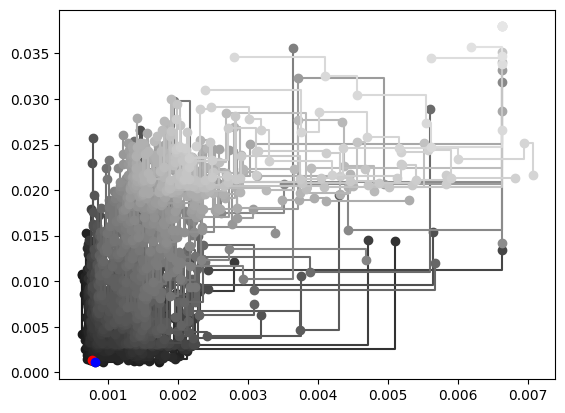

In [37]:
objs = [0,2]
pg.plot_non_dominated_fronts(all_f, comp = objs)
plt.plot(all_f[np.argmin((all_f.mean(1))), objs[0]], all_f[np.argmin((all_f.mean(1))), objs[1]], 'ro')
plt.plot(all_f[np.argmin((all_f**2).sum(1)**0.5), objs[0]], all_f[np.argmin((all_f**2).sum(1)**0.5), objs[1]], 'bo')

In [ ]:
    # Selection and replacement
    print(now() + ' - Starting migration ' + str(i))
    seleect_n = 50
    replace_n = 50
    XDB = makeXDB(seleect_n,pops) # this needs to make the global parameters 
    FDB = makeFDB(seleect_n,pops)
    replace = pickIDX(len(XDB),replace_n,len(pops))
    [[p.set_xf(k, XDB[i], FDB[i]) for i,k in zip(r,botN(replace_n,p))] for r,p in zip(replace,pops)]; # need to check if already in pop. this needs to make the problem-specific parameters
    # also need a way to set the variables for each problem, in all engines. 
    print(now() + ' - Migration done ' + str(i))

    with open('results/241025_M3/pops.dat', 'wb') as file:
        pickle.dump(pops, file)
    with open('results/241025_M3/logs.dat', 'wb') as file:
        pickle.dump(logs, file)

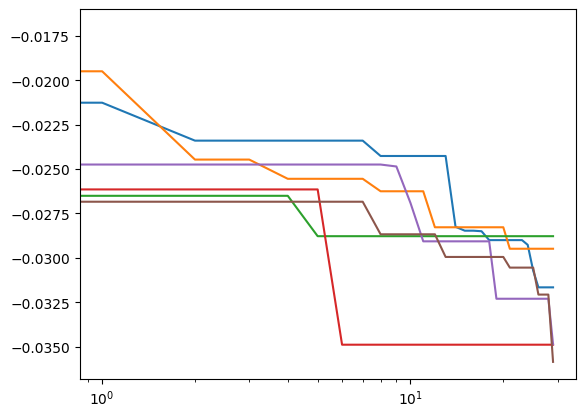

In [163]:
plt.plot(np.array([np.array(logs)[:,i,:,2].reshape(-1) for i in range(6)]).T)
plt.xscale('log')

In [24]:
test_myprob._setup_rr()
test_myprob.fitness(all_x[19])

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:563: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:




[4.49357649155153, 9533.93167373293, 1.3862685947010969, 1.20923264767534]

In [25]:
test_myprob.current_fitness

[0.8537795333947907,
 0.02984120613878407,
 1.0258387600788117,
 0.2902158354420816]

In [149]:
[p.champion_f for p in pops]

[array([0.00613227]),
 array([0.00628844]),
 array([0.00658463]),
 array([0.00673487]),
 array([0.00773904]),
 array([0.00606256])]

(array([ 18.,   2.,  14.,  10.,  66.,  61.,  16.,   1.,   6., 106.]),
 array([0.0729379 , 0.16555956, 0.25818123, 0.35080289, 0.44342455,
        0.53604622, 0.62866788, 0.72128954, 0.81391121, 0.90653287,
        0.99915453]),
 <BarContainer object of 10 artists>)

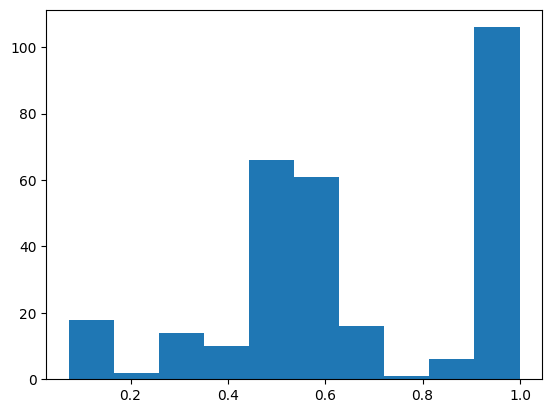

In [22]:
plt.hist(pops[0].get_x()[:,0])

In [25]:
len(logs)

22

In [26]:
len(pops[0].get_x()[:,0])

300

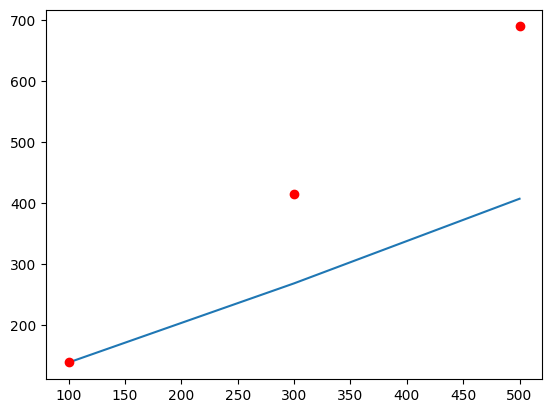

In [36]:
import matplotlib.pyplot as plt
plt.plot([100,300,500],[138,268,407])
plt.plot([100,300,500],[138,138*3,138*5],'ro')

In [17]:
test_myprob._setup_rr()

In [28]:
# all_test = []
# all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
# for k,c in enumerate([p_initial, train_myprob._unscale(pops[-1].get_x()[np.argsort(pops[0].get_f()[:,0])[:1],:])[0]]):
#     test_res = test_myprob._simulate(10**(c))
#     [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
#     all_test.append(test_res)

test_myprob._setup_rr()
# train_myprob._setup_rr()

all_test = []
all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate([all_x[754,:]]):
    test_res = test_myprob._simulate(10**(test_myprob._unscale(c)))
    # train_res = train_myprob._simulate(10**uc)
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_test.append(test_res)

NameError: name 'all_x' is not defined

In [42]:
compiled_results = {}
ms = test_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(test_index_map['index'],test_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = all_test[0][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
train_results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
train_results_df.columns =  ['sample', *ms.species_labels[ms.cols[i]]]

In [35]:
compiled_results = {}
ms = test_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(test_index_map['index'],test_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = all_test[0][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
train_results_df0 = pd.DataFrame.from_dict(compiled_results).T.reset_index()
train_results_df0.columns = ['sample', *ms.species_labels[ms.cols[i]]]

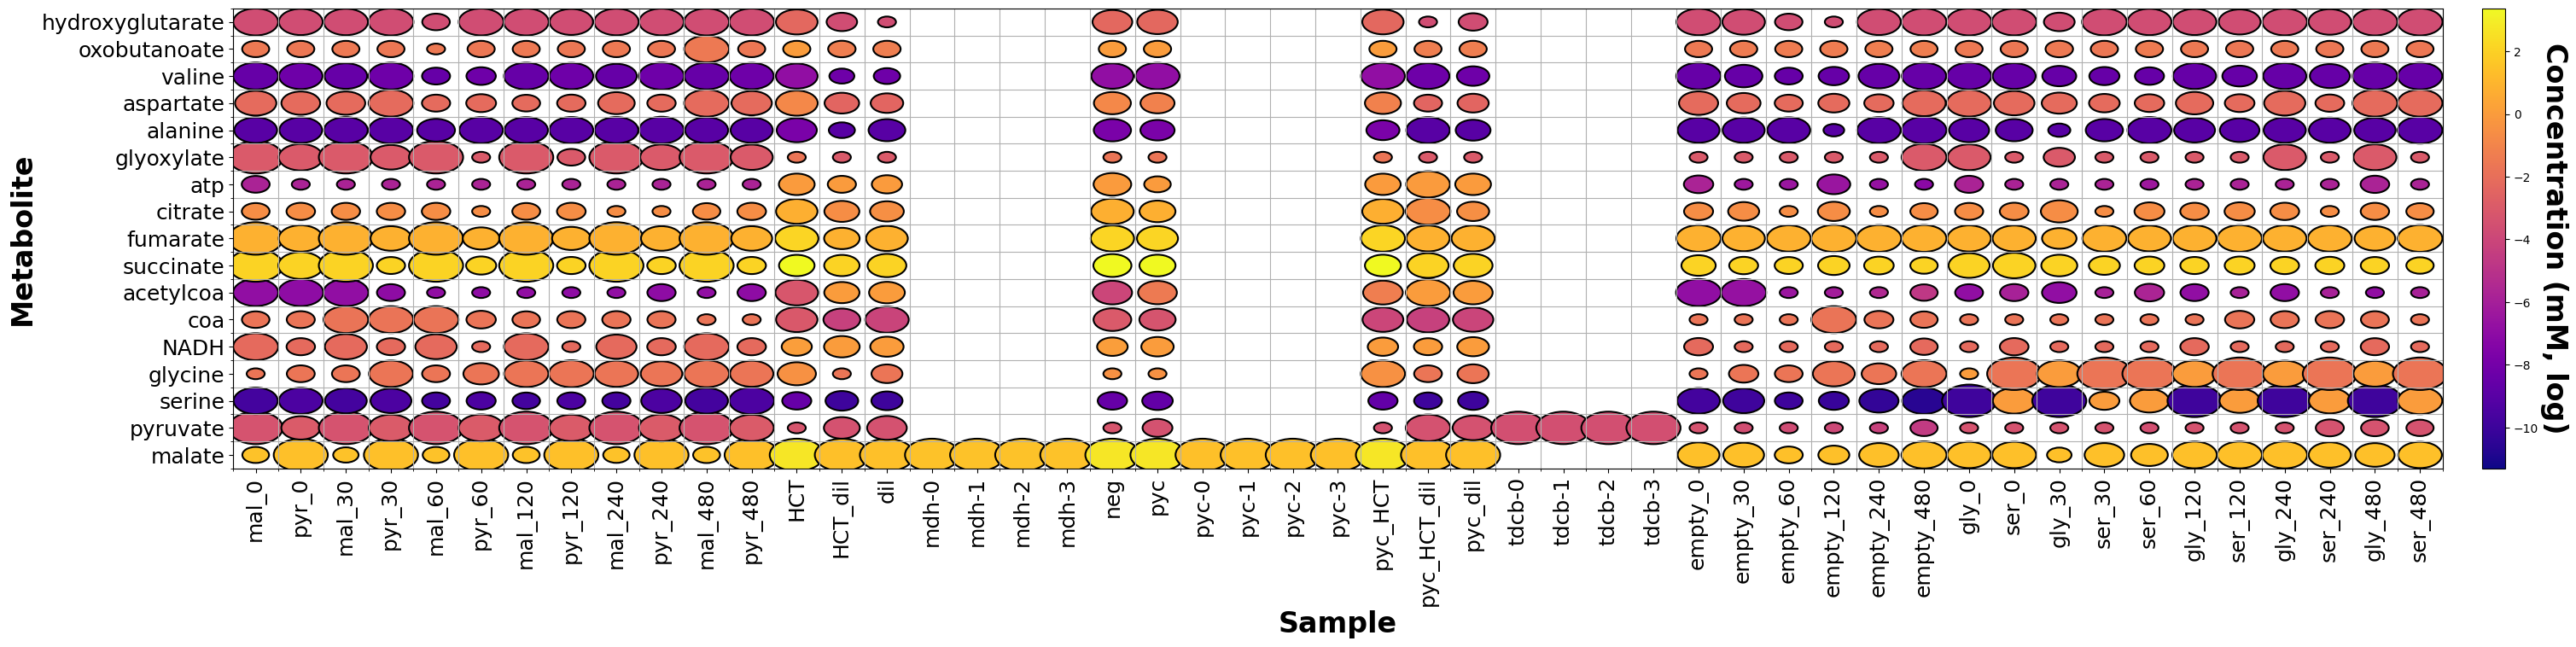

In [26]:
circlemap(train_results_df, test_weights_df.iloc[:,[0,*np.array(ms.data_cols[i])+1]])

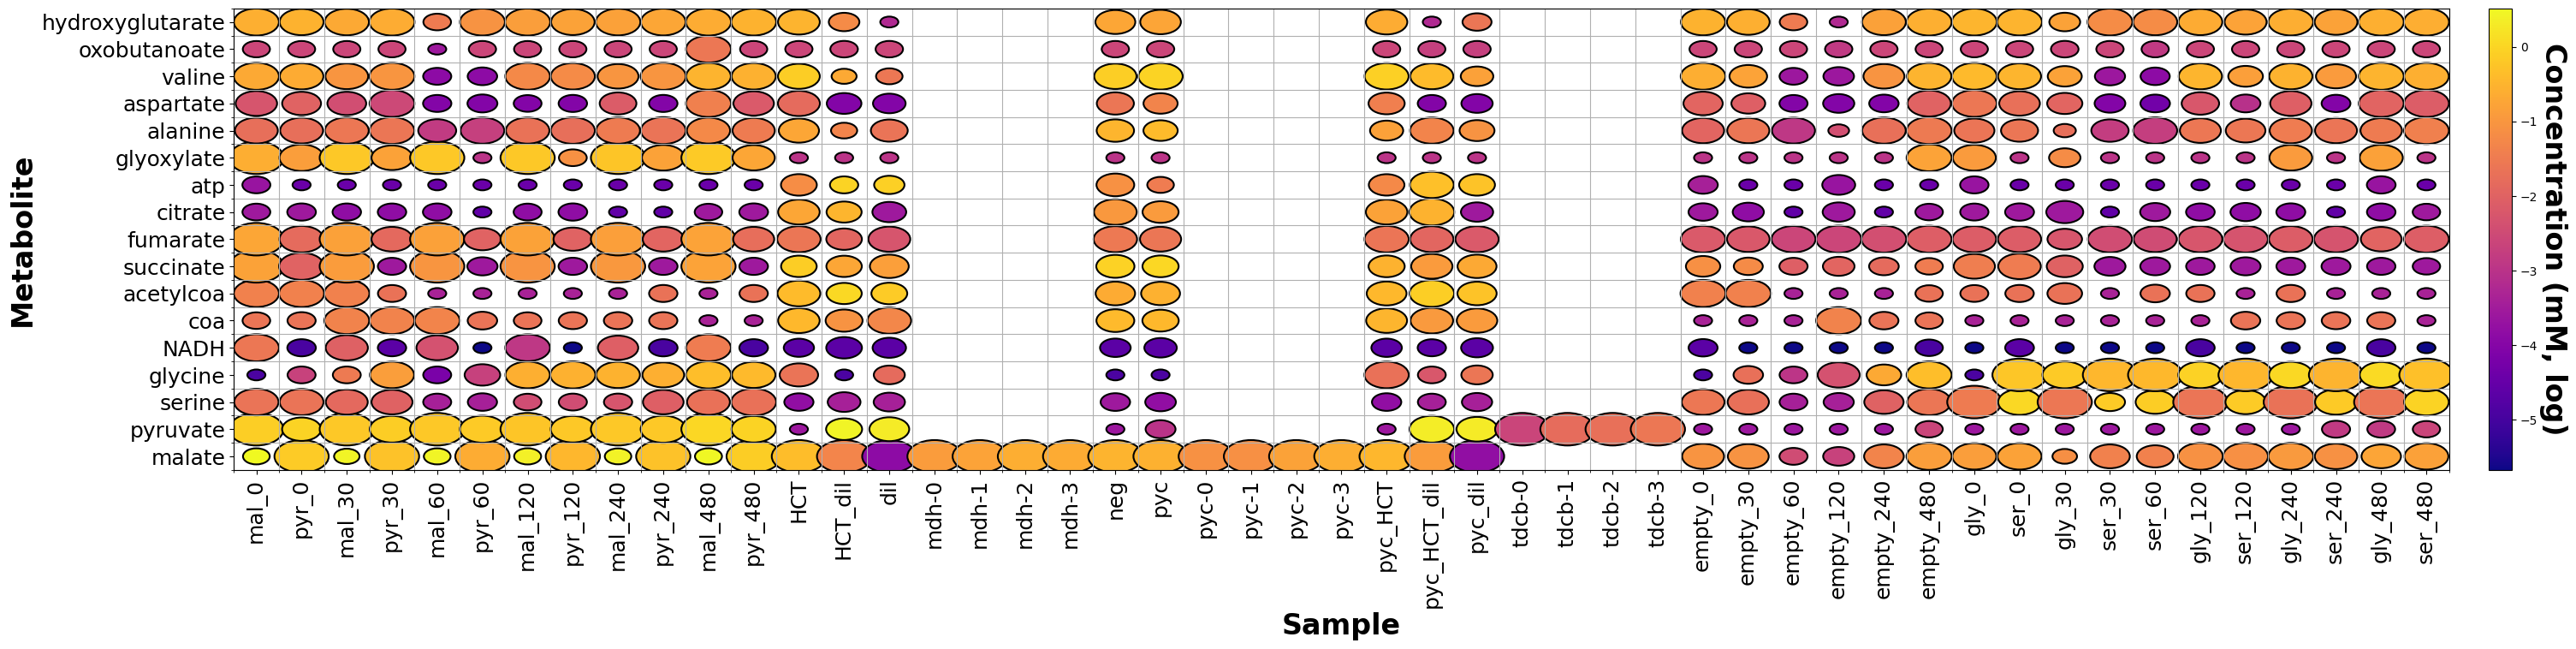

In [27]:
circlemap(test_data_df.iloc[:,[0,*np.array(ms.data_cols[i])+1]], test_weights_df.iloc[:,[0,*np.array(ms.data_cols[i])+1]])

In [28]:
train_results_df

sample      C00149    C00022        C00065    C00037    C00004  \
0         mal_0   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
1         pyr_0   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
2        mal_30   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
3        pyr_30   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
4        mal_60   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
5        pyr_60   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
6       mal_120   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
7       pyr_120   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
8       mal_240   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
9       pyr_240   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
10      mal_480   26.762438  0.000406  1.858103e-10  0.018524  0.005830   
11      pyr_480   25.359773  0.001128  3.669324e-10  0.018524  0.005830   
12          HCT  518.224333  0.000524  3.040784e-09  0.380718  1.109096   
13      HCT_dil   25.369809  0.000390  1.140411e-10  0.018525  0.991011   
14          dil   25.369256  0.000389  1.138247e-10  0.018525  0.991011   
15        mdh-0   26.670246  0.000002  1.271429e-11  0.018525  0.284652   
16        mdh-1   26.996336  0.000017  5.026068e-12  0.018525  0.996743   
17        mdh-2   27.180810  0.000017  4.971512e-12  0.018525  0.997624   
18        mdh-3   27.302136  0.000017  4.944767e-12  0.018525  0.998136   
19          neg  518.193818  0.000541  3.137695e-09  0.380717  1.110863   
20          pyc  519.194249  0.000382  2.216784e-09  0.380724  1.094793   
21        pyc-0   25.370226  0.000390  1.140329e-10  0.018525  0.994511   
22        pyc-1   25.370226  0.000390  1.140329e-10  0.018525  0.994511   
23        pyc-2   25.370226  0.000390  1.140329e-10  0.018525  0.994511   
24        pyc-3   25.370226  0.000390  1.140329e-10  0.018525  0.994511   
25      pyc_HCT  519.115064  0.000382  2.219009e-09  0.380725  1.082943   
26  pyc_HCT_dil   25.370269  0.000390  1.140622e-10  0.018525  0.994510   
27      pyc_dil   25.369348  0.000389  1.138424e-10  0.018525  0.994523   
28       tdcb-0   25.573044  0.000280  7.248595e-01  0.022603  0.005829   
29       tdcb-1   25.572174  0.000280  7.236503e-01  0.022603  0.005829   
30       tdcb-2   25.570459  0.000281  7.212661e-01  0.022604  0.005829   
31       tdcb-3   25.567945  0.000282  7.177717e-01  0.022604  0.005829   
32      empty_0   25.964657  0.000410  1.871009e-10  0.018524  0.005830   
33     empty_30   25.864962  0.000249  1.268454e-10  0.018525  0.005830   
34     empty_60   25.822529  0.000190  1.030342e-10  0.018526  0.005830   
35    empty_120   25.782166  0.000125  7.575232e-11  0.018527  0.005830   
36    empty_240   25.756859  0.000062  4.708763e-11  0.018529  0.005830   
37    empty_480   25.748727  0.000027  2.409067e-11  0.018533  0.005830   
38        gly_0   25.964637  0.000410  1.297432e-10  1.018494  0.005830   
39        ser_0   25.954395  0.000421  9.898108e-01  0.018879  0.005830   
40       gly_30   25.964637  0.000410  1.297432e-10  1.018494  0.005830   
41       ser_30   25.954395  0.000421  9.898108e-01  0.018879  0.005830   
42       ser_60   25.848469  0.000285  9.726748e-01  0.019268  0.005830   
43      gly_120   25.964637  0.000410  1.297432e-10  1.018494  0.005830   
44      ser_120   25.954395  0.000421  9.898108e-01  0.018879  0.005830   
45      gly_240   25.964637  0.000410  1.297432e-10  1.018494  0.005830   
46      ser_240   25.954395  0.000421  9.898108e-01  0.018879  0.005830   
47      gly_480   25.964637  0.000410  1.297432e-10  1.018494  0.005830   
48      ser_480   25.954395  0.000421  9.898108e-01  0.018879  0.005830   

      C00010        C00024       C00042      C00122    C00158        C00002  \
0   0.017219  1.385265e-07   116.683488    6.717886  0.241375  1.608807e-06   
1   0.017219  1.086845e-07   116.683487    6.365810  0.239968  1.775432e-06   
2   0.017219  1.38526

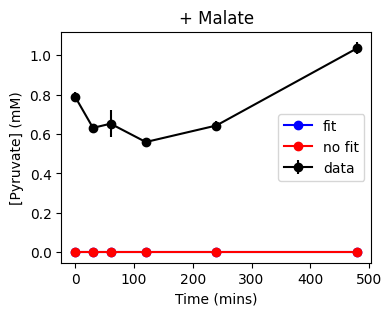

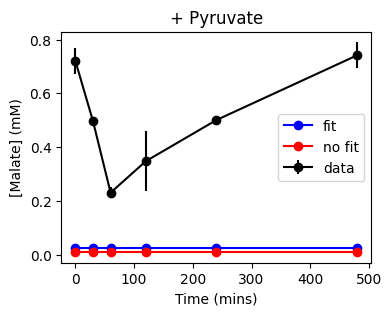

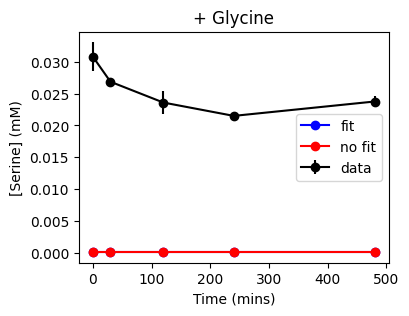

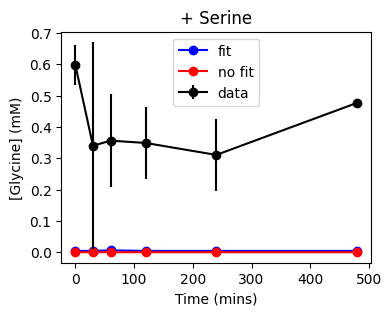

In [44]:
plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],train_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'], 'bo-')
plt.plot([0,30,60,120,240,480],train_results_df0.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'], 'ro-')
plt.errorbar([0,30,60,120,240,480],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].values,
 test_stds_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].values*2, fmt='o-', color='k')
# plt.errorbar([0,30,60,120,240,480],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'].values,
#  test_stds_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'].values*2, fmt='o-', color='k')

plt.xlabel('Time (mins)')
plt.ylabel('[Pyruvate] (mM)')
plt.title('+ Malate')
plt.legend(['fit','no fit','data'])

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],train_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 11]['sample']]['C00149'], 'bo-')
plt.plot([0,30,60,120,240,480],train_results_df0.set_index('sample').loc[test_index_map[test_index_map['index'] == 11]['sample']]['C00149'], 'ro-')
plt.errorbar([0,30,60,120,240,480],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 11]['sample']]['C00149'].values,
 test_stds_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 11]['sample']]['C00149'].values, fmt='o-', color='k')

plt.xlabel('Time (mins)')
plt.ylabel('[Malate] (mM)')
plt.title('+ Pyruvate')
plt.legend(['fit','no fit','data'])

plt.figure(figsize=(4,3))
plt.plot([0,30,120,240,480],train_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 0]['sample']]['C00065'], 'bo-')
plt.plot([0,30,120,240,480],train_results_df0.set_index('sample').loc[test_index_map[test_index_map['index'] == 0]['sample']]['C00065'], 'ro-')
plt.errorbar([0,30,120,240,480],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 0]['sample']]['C00065'].values,
 test_stds_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 0]['sample']]['C00065'].values, fmt='o-', color='k')

plt.xlabel('Time (mins)')
plt.ylabel('[Serine] (mM)')
plt.title('+ Glycine')
plt.legend(['fit','no fit','data'])

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],train_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00037'], 'bo-')
plt.plot([0,30,60,120,240,480],train_results_df0.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00037'], 'ro-')
plt.errorbar([0,30,60,120,240,480],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00037'].values,
 test_stds_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00037'].values, fmt='o-', color='k')

plt.xlabel('Time (mins)')
plt.ylabel('[Glycine] (mM)')
plt.title('+ Serine')
plt.legend(['fit','no fit','data'])

(0.0, 0.1)

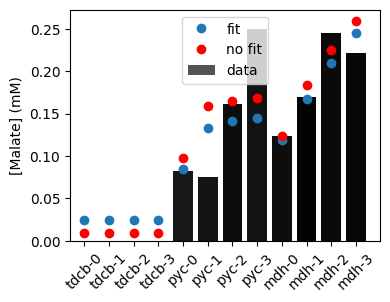

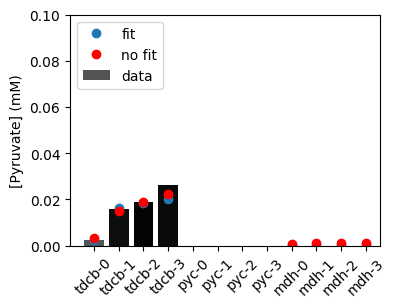

In [45]:
order = ['tdcb-0','tdcb-1','tdcb-2','tdcb-3','pyc-0','pyc-1','pyc-2','pyc-3','mdh-0','mdh-1','mdh-2','mdh-3']

plt.figure(figsize=(4,3))
ax = plt.bar(range(12), data_df.set_index('sample').loc[order]['C00149'],color='k', label='data')
for bar, alpha in zip(ax.patches, [*data_weights_df.set_index('sample').loc[order[:4]]['pyruvate'].values, *data_weights_df.set_index('sample').loc[order[4:]]['malate'].values]):
    bar.set_alpha(alpha/2)

plt.plot(range(12),train_results_df.set_index('sample').loc[order]['C00149'], 'o', label='fit')

plt.plot(range(12),train_results_df0.set_index('sample').loc[order]['C00149'], 'ro', label='no fit')

plt.xticks(range(12),order,rotation=45)
plt.legend()
plt.ylabel('[Malate] (mM)')

plt.figure(figsize=(4,3))
ax = plt.bar(range(12), data_df.set_index('sample').loc[order]['C00022'],color='k', label='data')
for bar, alpha in zip(ax.patches, [*data_weights_df.set_index('sample').loc[order[:4]]['pyruvate'].values, *data_weights_df.set_index('sample').loc[order[4:]]['malate'].values]):
    bar.set_alpha(alpha/2)

plt.plot(range(12),train_results_df.set_index('sample').loc[order]['C00022'], 'o', label='fit')

plt.plot(range(12),train_results_df0.set_index('sample').loc[order]['C00022'], 'ro', label='no fit')

plt.xticks(range(12),order,rotation=45)
plt.legend()
plt.ylabel('[Pyruvate] (mM)')
plt.ylim([0,0.1])

In [28]:
np.nansum(np.log1p(np.nansum(np.log1p(np.abs(test_res[0][0]-test_res[0][0]*0.9)),0)))

261.27672070929964

In [29]:
np.log1p(np.abs(test_res[0][0]-test_res[0][0]*0.02)).sum(0).shape

(387,)

In [98]:

for _,W,ms in zip(test_myprob.data,test_myprob.data_weights,test_myprob.model_stuff):
    for i,sample in enumerate(test_myprob.metadata[0]['sample_labels'][:0]):
        weights = W[sample]
        modelstuff = ms
        error = test_myprob.current_error[i]
        d_error = test_myprob.current_d_erorr[i]
        log_error = test_myprob.current_log_erorr[i]

        cols = modelstuff.cols[sample]
        rows = modelstuff.rows[sample]
        dcols = modelstuff.data_cols[sample]
        # appply error function, then weights
        wsq_e = (error**2)*weights[:,dcols]
        wsq_de = (d_error**2)*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
        wsq_le = (log_error**2)*weights[:,dcols]

        wl_e = np.log1p(np.abs(error))*weights[:,dcols]
        wl_de = np.log1p(np.abs(d_error))*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
        wl_le = np.log1p(np.abs(log_error))*weights[:,dcols]

        # sum acrross time and apply loss function
        wrmse_e = np.sqrt(np.nansum(wsq_e, axis=0)/np.count_nonzero(~np.isnan(wsq_e)))
        wrmse_de = np.sqrt(np.nansum(wsq_de, axis=0)/np.count_nonzero(~np.isnan(wsq_de)))
        wrmse_le = np.sqrt(np.nansum(wsq_le, axis=0)/np.count_nonzero(~np.isnan(wsq_le)))

        wll_e = np.log1p(np.nansum(wl_e, axis=0)/np.count_nonzero(~np.isnan(wl_e)))
        wll_de = np.log1p(np.nansum(wl_de, axis=0)/np.count_nonzero(~np.isnan(wl_de)))
        wll_le = np.log1p(np.nansum(wl_le, axis=0)/np.count_nonzero(~np.isnan(wl_le)))

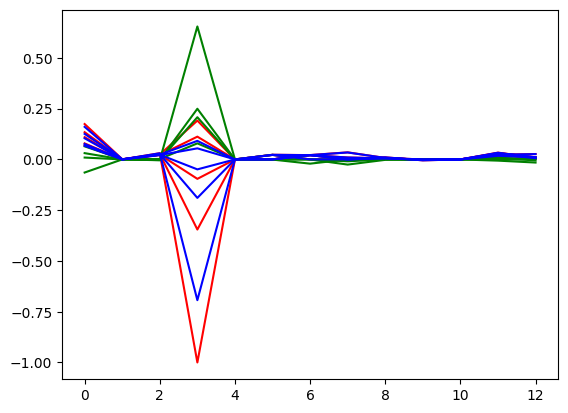

In [99]:
plt.plot(error.T,'r')
plt.plot(d_error.T,'g')
plt.plot(log_error.T,'b')

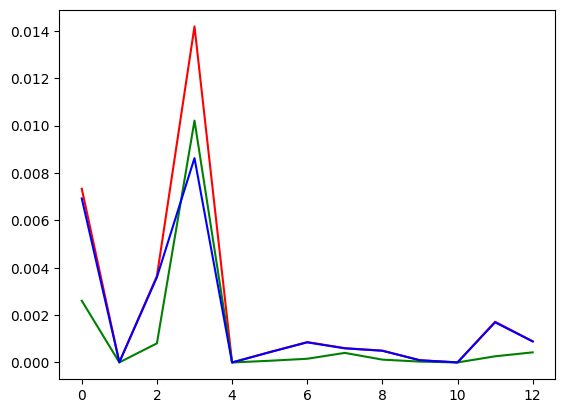

In [101]:
plt.plot(wll_e,'r')
plt.plot(wll_de,'g')
plt.plot(wll_le,'b')

In [22]:
bestN = lambda N: np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[pg.sort_population_mo(p.get_f())[:N],:]) for p in pops])
sampleM_fromN = lambda M,N: np.random.multivariate_normal(np.mean(bestN(N),0),np.cov(bestN(N),rowvar=False),size = M)

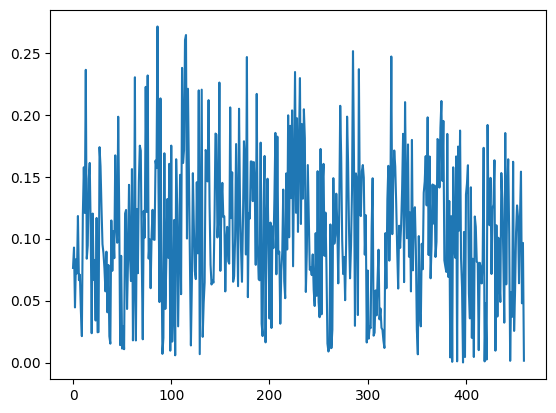

In [45]:
plt.plot(sampleM_fromN(5000,100).std(0))

In [65]:
plt.hist(bestN(30)[:,00])

array([ 7,  7,  4,  4, 11, 15,  4, 10,  6, 14,  8,  8,  6, 10, 10,  5, 12,
        9,  9, 16, 10,  4, 11,  3, 11,  5, 11, 16, 14,  7,  3,  4,  9,  7,
        8, 10,  4, 11, 15, 15,  5,  1,  2, 12,  5,  7,  4,  9,  6, 14, 11,
       11,  4,  1,  9,  3,  8,  5,  2,  3,  4, 10,  5,  0, 11,  4,  4,  5,
        4,  7,  9,  6,  5,  2,  6,  9,  3,  4,  6,  1,  5,  7,  9,  8,  5,
        5,  2,  6,  2,  2,  9,  5, 14,  5, 12,  9,  9, 10, 13, 12,  6, 11,
       19,  4, 17, 14, 14, 13, 14,  4, 11, 18, 11, 16, 18, 13, 14,  4, 13,
       15, 12, 13,  9,  8, 14, 12, 12,  8,  4,  5,  7,  6,  4,  9,  3, 12,
        6,  5,  6,  7,  8,  5, 11,  6,  6,  8,  5,  7,  6,  5, 11, 11, 14,
        2, 10, 12, 11, 15,  4, 15,  8,  7, 15,  8, 14, 12, 15, 12, 18,  5,
       13, 13, 13, 12, 13,  6, 18, 12,  8, 14])

In [100]:
xs = np.apply_along_axis(test_myprob._scale, 0, np.array([(np.random.uniform(p-w,p+w, 300)) for p,w in zip(p_initial,widths)])).T

(array([  1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,  23., 153.]),
 array([0.01562769, 0.11397392, 0.21232016, 0.31066639, 0.40901262,
        0.50735886, 0.60570509, 0.70405133, 0.80239756, 0.90074379,
        0.99909003]),
 <BarContainer object of 10 artists>)

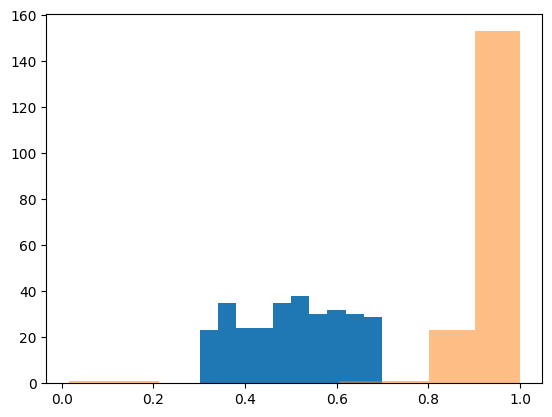

In [31]:
plt.hist(xs[0][:,270])
plt.hist(bestN(30)[:,270], alpha =0.5)

In [79]:
parameter_labels[100]

'Keq_R245'

In [81]:
widths[100]

0.3010299956639812

In [91]:
np.log10(3)

0.47712125471966244

In [95]:
p_initial[100] + widths[100]

6.257668500140908